In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 

In [52]:
#Please run all 3 cells.

#This cell only creates the class and methods; the cell below creates the Neuron object and runs the method for plotting and initializing circuit.

#All work done by Brandon Zhu

class Neuron():

    C_mem = 3 #membrane capacitance in uF
        
    g_NaMax = 0 #Maximum conductance of Na+ channels (originially 150)
    
    g_KMax = 36 #Maximum conductance of K+ channels
    
    g_LeakMax = .3 # Maximum conductance of leaky channels
    
    E_Na = 50 # Nernst potential of Na+ ion gradient (mV)
    
    E_K = -70 # Nernst potential of K+ ion gradient (mV)
    
    E_L = -50 #Nernst potential of leaky channel (mV)
      
    I_max = 150 #maximum input current (mA)
    
    dt = .001
    
    
    ## Determining the voltage dependent properties of the channels
    
    # Transition rate constants that determine the difference between gates opening/gates closing
    def m(self, V, m):
        #define alpha
        a = (0.1 * (25 - V)) / (np.exp((25 - V) / 10) - 1)
        # define beta
        b = 4 * np.exp(-V / 18)
        #eulers method to update the value of m
        m = m + ((a * (1-m)) - m * b ) * self.dt
        return m
    
    def n(self, V, n):
        #define alpha
        a = (0.01 * (10 - V)) / (np.exp((10 - V) / 10) - 1)
        # define beta
        b = 0.125 * np.exp((- V) / 80)
        n = n + ((a * (1-n)) - n * b ) * self.dt
        #eulers method to update the value of n
        return n
    
    def h(self, V, h):
        #define alpha
        a = 0.07 * np.exp((- V) / 20)
        # define beta
        b =  1 / (1 + np.exp((30 - V) / 10))
        #eulers method to update the value of n
        h = h + ((a * (1-h)) - h * b ) * self.dt
        return h
        
    #Functions for initial values, as defined by original Hodkin Huxley model
    def Pstart_m(self, V):
        a = (0.1 * (25 - V)) / (np.exp((25 - V) / 10) - 1)
        b = 4 * np.exp(-V / 18)
        
        Pstart = a/(a + b)
        return Pstart
    
    def Pstart_n(self, V):
        a = (0.01 * (10 - V)) / (np.exp((10 - V) / 10) - 1)
        b = 0.125 * np.exp((- V) / 80)
        Pstart = a/ ( a + b)
        return Pstart
    
    def Pstart_h(self, V):
        a = 0.07 * np.exp((- V) / 20)
        b =  1 / (1 + np.exp((30 - V) / 10))
        
        Pstart = a/(a+b)
        return Pstart
    

    def run(self):
       
        #set initial voltage and time arrays
        V1 = -60 
        times = np.arange(0 ,25,self.dt)
        Ntimes = len(times)
        
        #instantiate arrays for each variable V, m, n, h
        Varr = np.zeros(Ntimes)
        marr = np.zeros(Ntimes)
        narr = np.zeros(Ntimes)
        harr = np.zeros(Ntimes)
        iarr = np.zeros(Ntimes)
        #Define initial m,n, h values
        Pstart_m = self.Pstart_m(V1) 
        Pstart_n = self.Pstart_n(V1)
        Pstart_h = self.Pstart_h(V1)
        
        #store initial values
        Varr[0] = V1
        marr[0] = self.Pstart_m(V1)
        narr[0] = self.Pstart_n(V1)
        harr[0] = self.Pstart_h(V1)
        iarr[0] = 0
        #instante Time function for the impulse function below
        currentT = 0
        
        #loop through time steps
        for i in range(Ntimes-1):
            
            #inpulse function that inputs current into the circuit for two millseconds at a time with a 3 ms delay between each input
            input1 = (0 < currentT < 2 or 5 < currentT < 7 or 10 < currentT < 12 or 15 < currentT < 17 or 20 <currentT < 22 ) * self.I_max + (currentT<= 0 or 2 <= currentT <= 5 or 7 <=  currentT <= 10 or 12 <= currentT  <= 15 or 17 <= currentT <= 20 or currentT >= 22 ) * 0
            
            #store the new values of m,n,h by sending the current voltage and current m,n,h to our previously defined functions
            marr[i+1] = self.m(Varr[i], marr[i]) 
            #print("P_m: ", marr[i+1])
            narr[i+1] = self.n(Varr[i], narr[i])
            #print("P_n: ", narr[i])
            harr[i+1] = self.h(Varr[i], harr[i])
            #print("P_h: ",harr[i+1])
           
            # Calculate the current going through the circuit from each voltage gated channels
            I_Na = self.g_NaMax * marr[i] ** 3 * harr[i] * (Varr[i] - self.E_Na)
            I_K = self.g_KMax * narr[i] **4 * (Varr[i] - self.E_K)
            I_L = self.g_LeakMax * (Varr[i] - self.E_L)
            
            #define the change in V according to capacitor equation and use Euler's to update the current voltage, storing in our previous array.
            dV = (input1 - I_Na - I_K - I_L)/self.C_mem
            
            Varr[i+1] = Varr[i] + dV * self.dt
            
            #Loop the time up so that our impulse function works properly
            currentT = currentT + self.dt
            iarr[i] = input1
            #print(Varr[i+1])
        
        #Plot    
        plt.figure(figsize=(20, 4))
        
        plt.subplot(131)
        plt.title("Membrane Voltage as a function of time")
        plt.xlabel("Time [ms]")
        plt.ylabel("Membrane Voltage [mV]")
        plt.plot(times, Varr)
        plt.subplot(132)
        plt.title("Probability that each gate is open as a function of time")
        plt.xlabel("Time [ms]")
        plt.ylabel("Probability (P)")
        plt.plot(times, marr)
        plt.plot(times, narr)
        plt.plot(times, harr)
        plt.legend(['gating probability m', 'gating probability n', 'gating probability h'])
        plt.subplot(133)
        plt.title("External current as a function of time")
        plt.xlabel("Time [ms]")
        plt.ylabel("External current [mA]")
        plt.plot(times, iarr)
        plt.suptitle("Figure #)

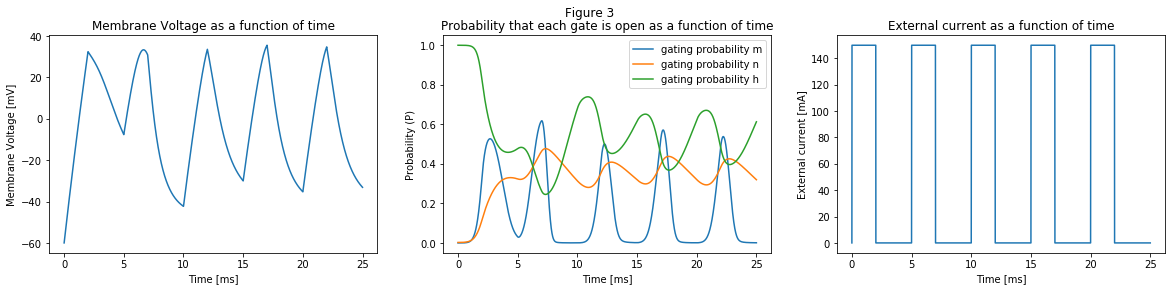

In [51]:
a = Neuron()
a.run()

